## Task
Try to predict death rate from cirrhosis

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read data

data = pd.read_csv('data.csv', delimiter=';', index_col='Index')
data.head(5)

,Urban,Latebirths,Wine,Liquor,CirrhosisDeath
Index,,,,,
1,44,33.2,5,30,41.2
2,43,33.8,4,41,31.7
3,48,40.6,3,38,39.4
4,52,39.2,7,48,57.5
5,71,45.5,11,53,74.8


In [3]:
# split into train and test dataset

ratio = 0.67
n_train = int(len(data) * ratio)
n_test = len(data) - n_train
indexes = np.zeros(data.shape[0])
indexes[np.random.choice(len(data), n_train, replace=False)] = 1

X = np.array(data[indexes == 1].values)[:,:-1]
y = np.array(data[indexes == 1].values)[:,-1]
test_x = np.array(data[indexes == 0].values)[:,:-1]
test_y = np.array(data[indexes == 0].values)[:,-1]

In [4]:
# regularize data

means, stds = X.mean(axis=0), X.std(axis=0)
X = (X - means) / stds

In [5]:
X = np.hstack((np.ones((X.shape[0], 1)), X))
X[:5]

array([[ 1.        , -0.80360804, -1.02819322, -1.05735107, -0.7091093 ],
       [ 1.        , -0.48471596, -0.05622187, -1.19119298, -0.83674897],
       [ 1.        , -0.2296023 , -0.25633362, -0.65582535, -0.41128339],
       [ 1.        ,  0.9821876 ,  0.64416925, -0.12045772, -0.1985506 ],
       [ 1.        , -0.73982962, -0.49932646, -0.38814153,  0.31200809]])

In [6]:
def mserror(y, y_pred):
    # mean square error of prediction
    return sum((y-y_pred)**2)

In [7]:
def linear_prediction(X, w):
    # linear prediction for X with weights w
    return X.dot(w)

$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\}$$

In [8]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    # count gradient for current iteration
    prediction = linear_prediction(X[train_ind], w)
    answer = y[train_ind]
    difference = prediction - answer
    grads = []
    grad_0 =  difference
    grads.append(grad_0)
    for i in range(1, len(X[train_ind])):
        grad_i = X[train_ind][i] * difference
        grads.append(grad_i)
    return  w - 2 * eta / len(X) * np.array(grads)

In [9]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # use stochastic gradient descent in order to find the most exact weights
    weight_dist = np.inf # init difference between current and previous weights
    w = w_init # init weights with given value
    errors = [] # errors between predicted and real results in dataset
    iter_num = 0
    np.random.seed(seed)
        
    while weight_dist > min_weight_dist and iter_num < max_iter:
        random_ind = np.random.randint(X.shape[0])
        
        w_moved = stochastic_gradient_step(X, y, w, random_ind, eta) # weights moved by gradiend descent
        weight_dist = np.sqrt(np.sum((w_moved-w)**2)) 
        w = w_moved
        
        y_pred = linear_prediction(X, w)
        errors.append(mserror(y, y_pred)) # count error on dataset
        if verbose:
            print(w)
        iter_num += 1
        
    return w, errors

In [10]:
%%time
w_init = np.full(X.shape[1], 0)
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, w_init, max_iter=1e5, verbose=False)
print(stoch_grad_desc_weights)

[ 63.16034723  -2.9633526   15.18488639  16.8520481   -2.98879879]
CPU times: user 3.05 s, sys: 3.67 ms, total: 3.05 s
Wall time: 3.04 s


Error by iter
Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

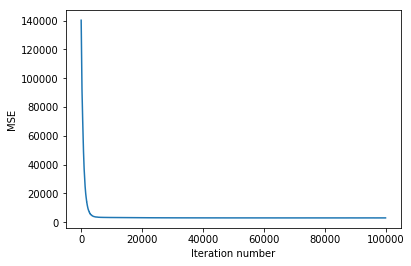

In [11]:
print ('Error by iter')
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

In [12]:
print ('Result error', stoch_errors_by_iter[-1])

Result error 3007.65626244


In [13]:
print ('Result weights')
stoch_grad_desc_weights

Result weights


array([ 63.16034723,  -2.9633526 ,  15.18488639,  16.8520481 ,  -2.98879879])

In [14]:
# means, stds from training data
test_x = (test_x - means) / stds

In [15]:
test_x = np.hstack((np.ones((test_x.shape[0], 1)), test_x))

In [16]:
test_y_pred = test_x.dot(stoch_grad_desc_weights)

In [17]:
test_y = pd.DataFrame(test_y)
test_y['Predicted'] = test_y_pred
test_y

,0,Predicted
0,41.2,36.392595
1,54.3,54.598416
2,80.9,72.915177
3,57.8,81.304247
4,62.8,44.519749
5,67.3,47.309175
6,37.6,36.767609
7,83.6,86.065822
8,66.0,62.610506
9,66.6,61.251910


## Conclusion
In this case linear regression has shown not so good results sometimes. I suppose because of small sample of data.